In [1]:
import numpy as np

from statsmodels.distributions.empirical_distribution import ECDF
from fairness.quantile import EQF


class BaseHelper():
    def __init__(self):
        self.ecdf = {}
        self.eqf = {}

    def _check_shape(y, x_ssa):
        if not isinstance(x_ssa, np.ndarray):
            raise ValueError('x_ssa_calib must be an array')

        if not isinstance(y, np.ndarray):
            raise ValueError('y_calib must be an array')

        if len(x_ssa) != len(y):
            raise ValueError('x_ssa_calib and y should have the same length')

    def _check_mod(sens_val_calib, sens_val_test):
        if sens_val_test > sens_val_calib:
            raise ValueError(
                'x_ssa_test should have at most the number of modalities in x_ssa_calib')

        if not all(elem in sens_val_calib for elem in sens_val_test):
            raise ValueError(
                'Modalities in x_ssa_test should be included in modalities of x_ssa_calib')

    def _get_mod(self,x_ssa):
        return list(set(x_ssa))

    def _get_loc(self, x_ssa):
        sens_loc = {}
        for mod in self._get_mod(x_ssa):
            sens_loc[mod] = np.where(x_ssa == mod)[0]
        return sens_loc

    def _get_weights(self, x_ssa):
        sens_loc = self._get_loc(x_ssa)
        weights = {}
        for mod in self._get_mod(x_ssa):
            # Calculate probabilities
            weights[mod] = len(sens_loc[mod])/len(x_ssa)
        return weights

    def _estimate_ecdf_eqf(self, y, x_ssa, sigma):
        sens_loc = self._get_loc(x_ssa)
        eps = np.random.uniform(-sigma, sigma, len(y))
        for mod in self._get_mod(x_ssa):
            # Fit the ecdf and eqf objects
            self.ecdf[mod] = ECDF(y[sens_loc[mod]] +
                                  eps[sens_loc[mod]])
            self.eqf[mod] = EQF(y[sens_loc[mod]]+eps[sens_loc[mod]])
            


class WassersteinNoBin(BaseHelper):
    def __init__(self, sigma=0.0001):
        BaseHelper.__init__(self)
        self.sigma = sigma

    def fit(self, y_calib, x_ssa_calib):
        BaseHelper._check_shape(y_calib, x_ssa_calib)

        self.sens_val_calib = BaseHelper._get_mod(self, x_ssa_calib)
        self.weights = BaseHelper._get_weights(self, x_ssa_calib)
        BaseHelper._estimate_ecdf_eqf(self, y_calib, x_ssa_calib, self.sigma)

    def transform(self, y_test, x_ssa_test):

        BaseHelper._check_shape(y_test, x_ssa_test)
        sens_val_test = BaseHelper._get_mod(self, x_ssa_test)
        BaseHelper._check_mod(self.sens_val_calib, sens_val_test)

        sens_loc = BaseHelper._get_loc(self, x_ssa_test)
        y_fair = np.zeros_like(y_test)
        eps = np.random.uniform(-self.sigma, self.sigma, len(y_test))
        for mod1 in sens_val_test:
            for mod2 in sens_val_test:
                y_fair[sens_loc[mod1]] += self.weights[mod2] * \
                    self.eqf[mod2](self.ecdf[mod1](
                        y_test[sens_loc[mod1]]+eps[sens_loc[mod1]]))

        return y_fair

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split

#from fairness import unfairness
#from fairness import WassersteinNoBin

In [3]:
size = 10000

age = np.random.randint(18, 66, size)

gender = np.random.choice(['m', 'w', 'nb'], size)

# Générer les salaires en fonction du genre en suivant les lois gamma spécifiées
salaries = []
for g in gender:
    if g == 'm':
        salary = np.random.gamma(20, 0.5)
    elif g == 'w':
        salary = np.random.gamma(2, 2)
    else:
        salary = np.random.gamma(0.5, 6)
    salaries.append(salary)

# Créer le DataFrame
df = pd.DataFrame({
    'Age': age,
    'Gender': gender,
    'Income': salaries
})

In [4]:
x_ssa = df['Gender'].to_numpy()
y_ssa = df['Income'].to_numpy()
x_ssa_calib, x_ssa_test, y_calib, y_test = train_test_split(x_ssa,y_ssa, test_size=0.3)

In [5]:
df_test = pd.DataFrame()
df_test['Gender'] = x_ssa_test
df_test['Income'] = y_test
display(df_test)

,Gender,Income
0,m,14.093032
1,nb,2.079157
2,nb,5.549321
3,nb,3.375529
4,w,10.094306
...,...,...
2995,m,13.837186
2996,m,10.944867
2997,w,5.443486
2998,w,9.817567


<Axes: xlabel='Income', ylabel='Density'>

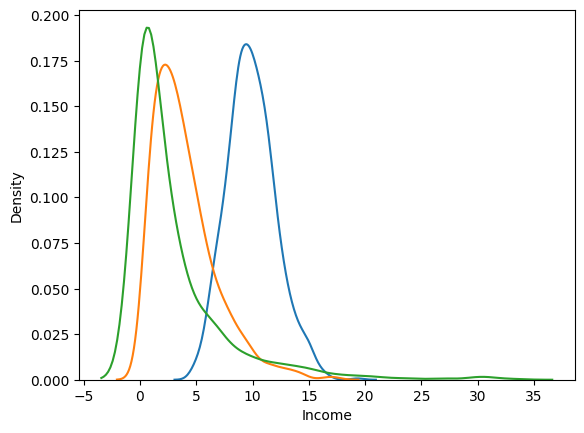

In [6]:
sns.kdeplot(df_test[df_test.Gender=='m'], x = df_test[df_test.Gender=='m']['Income'])
sns.kdeplot(df_test[df_test.Gender=='w'], x = df_test[df_test.Gender=='w']['Income'])
sns.kdeplot(df_test[df_test.Gender=='w'], x = df_test[df_test.Gender=='nb']['Income'])

In [7]:
import numpy as np

def diff_quantile(data1, data2):
    """
    compute the unfairness of two populations
    """
    probs = np.linspace(0, 1, num=100)
    eqf1 = np.quantile(data1, probs)
    eqf2 = np.quantile(data2, probs)
    unfair_value = np.max(np.abs(eqf1-eqf2))
    return unfair_value

def unfairness(y_fair, x_ssa_test):
    sens_val = list(set(x_ssa_test))
    data1 = y_fair
    lst_unfairness = []
    for mod in sens_val:
        data2 = y_fair[x_ssa_test==mod]
        lst_unfairness.append(diff_quantile(data1, data2))
    return max(lst_unfairness)

In [8]:
unfairness(y_test, x_ssa_test)

15.89139959616434

In [9]:
wst = WassersteinNoBin()
wst.fit(y_calib, x_ssa_calib)
y_fair = wst.transform(y_test,x_ssa_test)

In [10]:
df_fair = pd.DataFrame()
df_fair['Gender'] = x_ssa_test
df_fair['Income'] = y_fair

display(df_fair)

,Gender,Income
0,m,12.251771
1,nb,5.567937
2,nb,7.989203
3,nb,6.504125
4,w,12.087872
...,...,...
2995,m,11.775649
2996,m,6.333790
2997,w,6.980945
2998,w,11.827254


<Axes: xlabel='Income', ylabel='Density'>

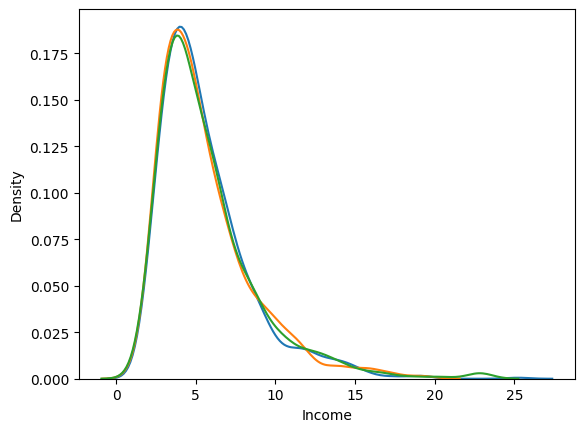

In [11]:
sns.kdeplot(df_fair[df_fair.Gender=='m'], x = df_fair[df_fair.Gender=='m']['Income'])
sns.kdeplot(df_fair[df_fair.Gender=='w'], x = df_fair[df_fair.Gender=='w']['Income'])
sns.kdeplot(df_fair[df_fair.Gender=='nb'], x = df_fair[df_fair.Gender=='nb']['Income'])

In [12]:
unfairness(y_fair, x_ssa_test)

5.86498999306372

In [57]:
from statsmodels.distributions.empirical_distribution import ECDF
from fairness.quantile import EQF
from sklearn.metrics import mean_squared_error, f1_score, accuracy_score
from itertools import permutations
import numpy as np

from statsmodels.distributions.empirical_distribution import ECDF
from fairness.quantile import EQF


class BaseHelper():
    def __init__(self):
        self.ecdf = {}
        self.eqf = {}

    def _check_shape(y, x_ssa):
        if not isinstance(x_ssa, np.ndarray):
            raise ValueError('x_ssa_calib must be an array')

        if not isinstance(y, np.ndarray):
            raise ValueError('y_calib must be an array')

        if len(x_ssa) != len(y):
            raise ValueError('x_ssa_calib and y should have the same length')

    def _check_mod(sens_val_calib, sens_val_test):
        if sens_val_test > sens_val_calib:
            raise ValueError(
                'x_ssa_test should have at most the number of modalities in x_ssa_calib')

        if not all(elem in sens_val_calib for elem in sens_val_test):
            raise ValueError(
                'Modalities in x_ssa_test should be included in modalities of x_ssa_calib')

    def _get_mod(self,x_ssa):
        return list(set(x_ssa))

    def _get_loc(self, x_ssa):
        sens_loc = {}
        for mod in self._get_mod(x_ssa):
            sens_loc[mod] = np.where(x_ssa == mod)[0]
        return sens_loc

    def _get_weights(self, x_ssa):
        sens_loc = self._get_loc(x_ssa)
        weights = {}
        for mod in self._get_mod(x_ssa):
            # Calculate probabilities
            weights[mod] = len(sens_loc[mod])/len(x_ssa)
        return weights

    def _estimate_ecdf_eqf(self, y, x_ssa, sigma):
        sens_loc = self._get_loc(x_ssa)
        eps = np.random.uniform(-sigma, sigma, len(y))
        for mod in self._get_mod(x_ssa):
            # Fit the ecdf and eqf objects
            self.ecdf[mod] = ECDF(y[sens_loc[mod]] +
                                  eps[sens_loc[mod]])
            self.eqf[mod] = EQF(y[sens_loc[mod]]+eps[sens_loc[mod]])
            


class WassersteinNoBin(BaseHelper):
    def __init__(self, sigma=0.0001):
        BaseHelper.__init__(self)
        self.sigma = sigma
        self.sens_val_calib = None
        self.weights = None

    def fit(self, y_calib, x_ssa_calib):
        BaseHelper._check_shape(y_calib, x_ssa_calib)

        self.sens_val_calib = BaseHelper._get_mod(self, x_ssa_calib)
        self.weights = BaseHelper._get_weights(self, x_ssa_calib)
        BaseHelper._estimate_ecdf_eqf(self, y_calib, x_ssa_calib, self.sigma)

    def transform(self, y_test, x_ssa_test):

        BaseHelper._check_shape(y_test, x_ssa_test)
        sens_val_test = BaseHelper._get_mod(self, x_ssa_test)
        BaseHelper._check_mod(self.sens_val_calib, sens_val_test)

        sens_loc = BaseHelper._get_loc(self, x_ssa_test)
        y_fair = np.zeros_like(y_test)
        eps = np.random.uniform(-self.sigma, self.sigma, len(y_test))
        for mod1 in sens_val_test:
            for mod2 in sens_val_test:
                y_fair[sens_loc[mod1]] += self.weights[mod2] * \
                    self.eqf[mod2](self.ecdf[mod1](
                        y_test[sens_loc[mod1]]+eps[sens_loc[mod1]]))

        return y_fair


class MultiWasserStein(WassersteinNoBin):
    def __init__(self, sigma=0.0001):
        WassersteinNoBin.__init__(self, sigma=sigma)

        # self.y_fair_calib_all = {}
        self.y_fair_test = {}

        self.sens_val_calib_all = {}
        self.weights_all = {}

        self.eqf_all = {}
        self.ecdf_all = {}

    def fit(self, y_calib, x_ssa_calib):
        for i, sens in enumerate(x_ssa_calib.T):
            if i == 0:
                y_calib_inter = y_calib
            wasserstein_instance = WassersteinNoBin(sigma=self.sigma)
            wasserstein_instance.fit(y_calib_inter, sens)
            self.sens_val_calib_all[f'sens_var_{i+1}'] = wasserstein_instance.sens_val_calib
            self.weights_all[f'sens_var_{i+1}'] = wasserstein_instance.weights
            self.eqf_all[f'sens_var_{i+1}'] = wasserstein_instance.eqf
            self.ecdf_all[f'sens_var_{i+1}'] = wasserstein_instance.ecdf
            y_calib_inter = wasserstein_instance.transform(y_calib_inter, sens)
            # self.y_fair_calib_all[f'sens_var_{i+1}'] = y_calib_inter

    def transform(self, y_test, x_ssa_test):
        for i, sens in enumerate(x_ssa_test.T):
            if i == 0:
                y_test_inter = y_test
            wasserstein_instance = WassersteinNoBin(sigma=self.sigma)
            wasserstein_instance.sens_val_calib = self.sens_val_calib_all[f'sens_var_{i+1}']
            wasserstein_instance.weights = self.weights_all[f'sens_var_{i+1}']
            wasserstein_instance.eqf = self.eqf_all[f'sens_var_{i+1}']
            wasserstein_instance.ecdf = self.ecdf_all[f'sens_var_{i+1}']
            y_test_inter = wasserstein_instance.transform(y_test_inter, sens)
            self.y_fair_test[f'sens_var_{i+1}'] = y_test_inter
        #return self.y_fair_test[f'sens_var_{i+1}']
        return self.y_fair_test

In [14]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split

#from fairness import unfairness
#from fairness import WassersteinNoBin

In [15]:
size = 10000

age = np.random.randint(18, 66, size)

gender = np.random.choice(['m', 'w', 'nb'], size)

nb_child = np.random.choice([0,1,2], size)

# Générer les salaires en fonction du genre en suivant les lois gamma spécifiées
salaries = []
for g in gender:
    if g == 'm':
        salary = np.random.gamma(20, 0.5)
    elif g == 'w':
        salary = np.random.gamma(2, 2)
    else:
        salary = np.random.gamma(0.5, 6)
    salaries.append(salary)
   
for i, n in enumerate(nb_child):
    if n == 0:
        salaries[i] += np.random.binomial(6, 0.75)
    elif g == 1:
        salaries[i] += np.random.binomial(5, 0.66)
    else:
        salaries[i] += np.random.binomial(1, 0.2)
    

# Créer le DataFrame
df = pd.DataFrame({
    'Age': age,
    'Gender': gender,
    'Nb_child': nb_child,
    'Income': salaries
})

In [16]:
x_ssa = df[['Gender','Nb_child']].to_numpy()
y_ssa = df['Income'].to_numpy()
x_ssa_calib, x_ssa_test, y_calib, y_test = train_test_split(x_ssa,y_ssa, test_size=0.3)

In [17]:
df_test = pd.DataFrame()
df_test[['Gender','Nb_child']] = x_ssa_test
df_test['Income'] = y_test
display(df_test)

,Gender,Nb_child,Income
0,m,1,11.203041
1,w,1,2.974935
2,m,2,8.028321
3,nb,1,4.650205
4,m,1,10.012547
...,...,...,...
2995,m,0,14.961032
2996,w,0,10.890952
2997,w,2,5.154178
2998,w,1,7.965028


<Axes: xlabel='Income', ylabel='Density'>

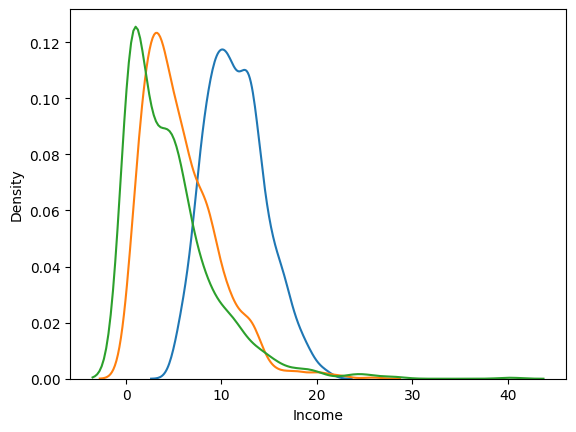

In [49]:
sns.kdeplot(df_test[df_test.Gender=='m'], x = df_test[df_test.Gender=='m']['Income'])
sns.kdeplot(df_test[df_test.Gender=='w'], x = df_test[df_test.Gender=='w']['Income'])
sns.kdeplot(df_test[df_test.Gender=='w'], x = df_test[df_test.Gender=='nb']['Income'])

<Axes: xlabel='Income', ylabel='Density'>

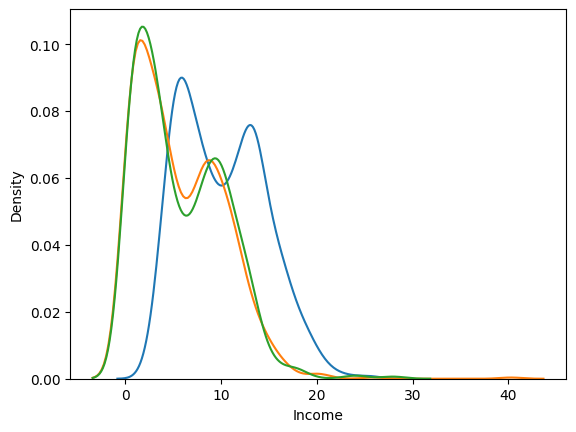

In [19]:
sns.kdeplot(df_test[df_test.Nb_child==0], x = df_test[df_test.Nb_child==0]['Income'])
sns.kdeplot(df_test[df_test.Nb_child==1], x = df_test[df_test.Nb_child==1]['Income'])
sns.kdeplot(df_test[df_test.Nb_child==2], x = df_test[df_test.Nb_child==2]['Income'])

In [58]:
wst = MultiWasserStein()
wst.fit(y_calib, x_ssa_calib)
y_fair = wst.transform(y_test,x_ssa_test)

In [61]:
y_fair.values()

dict_values([array([6.5560188 , 4.45354939, 3.24958683, ..., 6.80085507, 9.58880947,
       4.1618513 ]), array([ 8.07161607,  5.87546417,  4.56394092, ...,  8.25880828,
       11.13707113,  5.57435185])])

In [51]:
df_fair = pd.DataFrame()
df_fair[['Gender','Nb_child']] = x_ssa_test
df_fair['Income'] = y_fair

display(df_fair)

,Gender,Nb_child,Income
0,m,1,8.070836
1,w,1,5.875138
2,m,2,4.564898
3,nb,1,8.903281
4,m,1,6.517577
...,...,...,...
2995,m,0,7.604979
2996,w,0,9.816395
2997,w,2,8.257453
2998,w,1,11.141526


<Axes: xlabel='Income', ylabel='Density'>

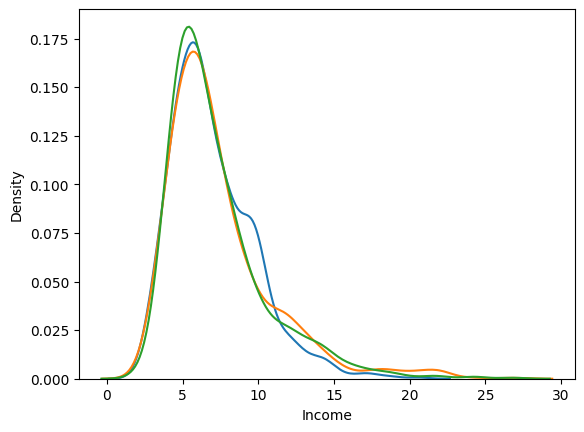

In [52]:
sns.kdeplot(df_fair[df_fair.Gender=='m'], x = df_fair[df_fair.Gender=='m']['Income'])
sns.kdeplot(df_fair[df_fair.Gender=='w'], x = df_fair[df_fair.Gender=='w']['Income'])
sns.kdeplot(df_fair[df_fair.Gender=='nb'], x = df_fair[df_fair.Gender=='nb']['Income'])

<Axes: xlabel='Income', ylabel='Density'>

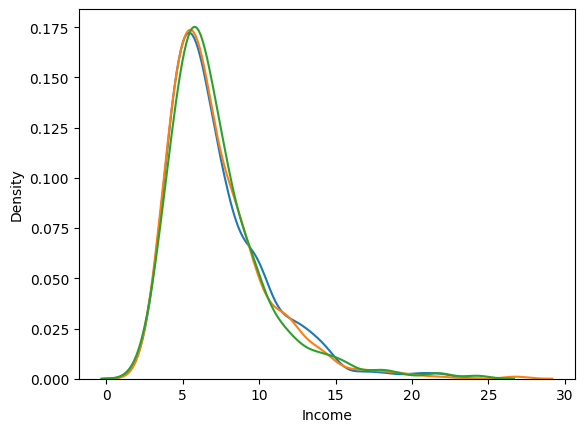

In [54]:
sns.kdeplot(df_fair[df_fair.Nb_child==0], x = df_fair[df_fair.Nb_child==0]['Income'])
sns.kdeplot(df_fair[df_fair.Nb_child==1], x = df_fair[df_fair.Nb_child==1]['Income'])
sns.kdeplot(df_fair[df_fair.Nb_child==2], x = df_fair[df_fair.Nb_child==2]['Income'])

In [56]:
unfairness(y_test, x_ssa_test)

TypeError: unhashable type: 'numpy.ndarray'

In [55]:
unfairness(y_fair, x_ssa_test)

TypeError: unhashable type: 'numpy.ndarray'